In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import text,sequence

from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM

with open("train.txt", "rb") as f:   #list of tuples
    train =  pickle.load(f)
with open("test.txt", "rb") as f:   
    test =  pickle.load(f)

Using TensorFlow backend.


In [2]:
len(train)

10000

In [3]:
len(test)

1000

In [4]:
# Combining train and test data into a dataframe
data = train + test

df_dict = {"story":[' '.join(tp[0]) for tp in data],"question":[' '.join(tp[1]) for tp in data],"answer":[tp[2] for tp in data]}
df = pd.DataFrame(df_dict)

In [5]:
df.head()

,story,question,answer
0,Mary moved to the bathroom . Sandra journeyed ...,Is Sandra in the hallway ?,no
1,Mary moved to the bathroom . Sandra journeyed ...,Is Daniel in the bathroom ?,no
2,Mary moved to the bathroom . Sandra journeyed ...,Is Daniel in the office ?,no
3,Mary moved to the bathroom . Sandra journeyed ...,Is Daniel in the bedroom ?,yes
4,Mary moved to the bathroom . Sandra journeyed ...,Is Daniel in the bedroom ?,yes


In [9]:
# corpus to find vocabulary 
corpus = []

for i in range(len(data)):
    whole_text = df['story'][i] +' '+ df['question'][i] +' '+ df['answer'][i]
    corpus.append(whole_text)

In [10]:
# using countvectorizer to find the vocabulary
vectorizer = CountVectorizer(token_pattern = r"(?u)\b\w\w+\b|!|\?|\"|\'|\.")
X = vectorizer.fit_transform(corpus)

In [11]:
# words in vocabulary
list(vectorizer.vocabulary_.keys())

['mary',
 'moved',
 'to',
 'the',
 'bathroom',
 '.',
 'sandra',
 'journeyed',
 'bedroom',
 'is',
 'in',
 'hallway',
 '?',
 'no',
 'went',
 'back',
 'daniel',
 'kitchen',
 'office',
 'picked',
 'up',
 'football',
 'there',
 'yes',
 'john',
 'travelled',
 'garden',
 'got',
 'apple',
 'put',
 'down',
 'grabbed',
 'left',
 'dropped',
 'took',
 'milk',
 'discarded']

In [12]:
vocabulary = list(vectorizer.vocabulary_)

In [13]:
# adding a placeholder for when using keras pad_sequences

vocab_len = len(vocabulary) + 1
vocab_len

38

In [11]:
# can be used to create vocabulary

#from tensorflow.keras.preprocessing import text, sequence

#tokenizer = Tokenizer(filters=[])

#for text in [df.story.values,df.question.values,df.answer.values]:
#    tokenizer.fit_on_texts(text)

In [14]:
# finding the maximum story length for padding seuqences

max_story_len = max([len(tp[0]) for tp in data]) 
max_question_len = max([len(tp[1]) for tp in data]) 

In [15]:
#np.argmax(np.array([len(tp[0]) for tp in data]))

In [16]:
max_story_len

156

In [17]:
max_question_len

6

In [18]:
# integer encoding words
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocabulary)

In [19]:
word_index = tokenizer.word_index # lower-cased automatically

In [20]:
train_dict = {"story":[' '.join(tp[0]) for tp in train],"question":[' '.join(tp[1]) for tp in train],"answer":[tp[2] for tp in train]}
train_df = pd.DataFrame(train_dict)

test_dict = {"story":[' '.join(tp[0]) for tp in test],"question":[' '.join(tp[1]) for tp in test],"answer":[tp[2] for tp in test]}
test_df = pd.DataFrame(test_dict)

In [21]:
train_df.head()

,story,question,answer
0,Mary moved to the bathroom . Sandra journeyed ...,Is Sandra in the hallway ?,no
1,Mary moved to the bathroom . Sandra journeyed ...,Is Daniel in the bathroom ?,no
2,Mary moved to the bathroom . Sandra journeyed ...,Is Daniel in the office ?,no
3,Mary moved to the bathroom . Sandra journeyed ...,Is Daniel in the bedroom ?,yes
4,Mary moved to the bathroom . Sandra journeyed ...,Is Daniel in the bedroom ?,yes


In [22]:
test_df.head()

,story,question,answer
0,Mary got the milk there . John moved to the be...,Is John in the kitchen ?,no
1,Mary got the milk there . John moved to the be...,Is John in the kitchen ?,no
2,Mary got the milk there . John moved to the be...,Is John in the garden ?,yes
3,Mary got the milk there . John moved to the be...,Is Daniel in the bathroom ?,yes
4,Mary got the milk there . John moved to the be...,Is Daniel in the bedroom ?,no


In [23]:
def compute_story_and_questions(dframe, tokenizer):
    
    story = tokenizer.texts_to_sequences(dframe.story.values)
    question = tokenizer.texts_to_sequences(dframe.question.values)

    story = sequence.pad_sequences(story, maxlen=156)
    question = sequence.pad_sequences(question, maxlen=6)
    
    return story, question

In [24]:
inputs_train, questions_train = compute_story_and_questions(train_df,tokenizer)
inputs_test, questions_test = compute_story_and_questions(test_df,tokenizer)

In [25]:
def compute_answer(dframe):
    
    answers = []
    
    for yes_no in dframe.answer.values:
        
        y = np.zeros(len(word_index) + 1)    
        y[word_index[yes_no]] = 1
        answers.append(y)
    
    return np.array(answers)

In [26]:
answers_train = compute_answer(train_df)
answers_test = compute_answer(test_df)

In [27]:
sum(answers_train) # number of yes and no in training set

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0., 4988.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0., 5012.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.])

In [28]:
# 2 inputs ( story and question ) 
# creating placeholders for inputs

input_sequence = Input(shape = (max_story_len,))
input_question = Input(shape = (max_question_len,))

In [29]:
# creating input encoders m, c and question encoder

# output of input_encoder_m in the format of (batch_size, 156, 64)
encoder_m = Sequential()
encoder_m.add(Embedding(input_dim=vocab_len,output_dim=64,input_length=156))
encoder_m.add(Dropout(0.3))

# output of input_encoder_m in the format of (batch_size, 156, 6)
encoder_c = Sequential()
encoder_c.add(Embedding(input_dim=vocab_len,output_dim=6,input_length=156))
encoder_c.add(Dropout(0.3))

# output of input_encoder_m in the format of (batch_size, 6, 64)
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_len,output_dim=64,input_length=6))
question_encoder.add(Dropout(0.3))

In [30]:
# encoding sequences

# passing place holders through encoders
result_m = encoder_m(input_sequence) 
result_c = encoder_c(input_sequence)
result_q = question_encoder(input_question)

dt = dot([result_m, result_q], axes=(2, 2))
p = Activation('softmax')(dt)

# adding the p matrix with the input vector c sequence
o = add([p, result_c])  # (samples, 156, 6)
o = Permute((2, 1))(o)  # (samples, 6, 156)

# concatenating the o matrix with the question vector sequence
W = concatenate([o,result_q])

In [31]:
# reducing W with RNN (LSTM)
W = LSTM(32)(W)  

# Regularization 
W = Dropout(0.5)(W)
W = Dense(vocab_len)(W)  # (batch_size, vocab_size)

# outputing a probability distribution over the vocabulary
W = Activation('softmax')(W)

In [32]:
# building the model
model = Model([input_sequence, input_question], outputs = W)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 156, 64)      2432        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 6, 64)        2432        input_2[0][0]                    
____________________________________________________________________________________________

In [34]:
history = model.fit(x=[inputs_train,questions_train],
                    y=answers_train,
                    batch_size=32,
                    epochs=100,
                    validation_data=([inputs_test,questions_test],answers_test))

C:\Users\WorkPC\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 10000 samples, validate on 1000 samples
Epoch 1/100
10000/10000 [==============================] - 5s 453us/step - loss: 0.9524 - accuracy: 0.4970 - val_loss: 0.6945 - val_accuracy: 0.5030
Epoch 2/100
10000/10000 [==============================] - 3s 336us/step - loss: 0.7085 - accuracy: 0.5001 - val_loss: 0.6937 - val_accuracy: 0.5030
Epoch 3/100
10000/10000 [==============================] - 3s 335us/step - loss: 0.6969 - accuracy: 0.4993 - val_loss: 0.6933 - val_accuracy: 0.5030
Epoch 4/100
10000/10000 [==============================] - 3s 335us/step - loss: 0.6950 - accuracy: 0.5006 - val_loss: 0.6939 - val_accuracy: 0.4970
Epoch 5/100
10000/10000 [==============================] - 3s 335us/step - loss: 0.6946 - accuracy: 0.4999 - val_loss: 0.6932 - val_accuracy: 0.4970
Epoch 6/100
10000/10000 [==============================] - 3s 335us/step - loss: 0.6944 - accuracy: 0.5052 - val_loss: 0.6942 - val_accuracy: 0.4970
Epoch 7/100
10000/10000 [==============================] 

10000/10000 [==============================] - 4s 376us/step - loss: 0.3163 - accuracy: 0.8655 - val_loss: 0.4007 - val_accuracy: 0.8240
Epoch 56/100
10000/10000 [==============================] - 4s 377us/step - loss: 0.3151 - accuracy: 0.8625 - val_loss: 0.3904 - val_accuracy: 0.8310
Epoch 57/100
10000/10000 [==============================] - 4s 376us/step - loss: 0.3153 - accuracy: 0.8689 - val_loss: 0.3996 - val_accuracy: 0.8300
Epoch 58/100
10000/10000 [==============================] - 4s 377us/step - loss: 0.3131 - accuracy: 0.8633 - val_loss: 0.3819 - val_accuracy: 0.8350
Epoch 59/100
10000/10000 [==============================] - 4s 377us/step - loss: 0.3057 - accuracy: 0.8715 - val_loss: 0.4116 - val_accuracy: 0.8170
Epoch 60/100
10000/10000 [==============================] - 4s 375us/step - loss: 0.3124 - accuracy: 0.8649 - val_loss: 0.3995 - val_accuracy: 0.8280
Epoch 61/100
10000/10000 [==============================] - 4s 377us/step - loss: 0.3041 - accuracy: 0.8697 - val

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


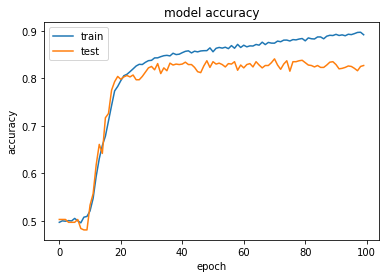

In [35]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
#saving the model
model.save("100_epochs.h5")

In [36]:
# getting predictions for test set
predictions = model.predict(([inputs_test, questions_test]))

In [37]:
test_df.iloc[0]

story       Mary got the milk there . John moved to the be...
question                             Is John in the kitchen ?
answer                                                     no
Name: 0, dtype: object

In [38]:
# generating a prediction from model for first story/question/answer (test_df.iloc[0])
val_max = np.argmax(predictions[0])

for key, val in word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of the answer: ", predictions[0][val_max])

Predicted answer is:  no
Probability of the answer:  0.9998734


In [39]:
# for testing our own cases, we must stick to the current vocabulary

my_story = "Mary left the bedroom . John dropped the football in the hallway ."
my_story.split() # punctuation is seperated as in format as it was trained on

['Mary',
 'left',
 'the',
 'bedroom',
 '.',
 'John',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'hallway',
 '.']

In [40]:
my_question = "Is the football in the bedroom ?"
my_question.split()

['Is', 'the', 'football', 'in', 'the', 'bedroom', '?']

In [41]:
# creating test cases. same format as our data (tuple)
my_data = [(my_story.split(),my_question.split(),'no')]

In [42]:
my_dict = {"story":[' '.join(tp[0]) for tp in my_data],
           "question":[' '.join(tp[1]) for tp in my_data],
           "answer":[tp[2] for tp in my_data]}

my_df = pd.DataFrame(my_dict)
my_df.head()

,story,question,answer
0,Mary left the bedroom . John dropped the footb...,Is the football in the bedroom ?,no


In [43]:
my_story , my_question = compute_story_and_questions(my_df,tokenizer)
my_answer = compute_answer(my_df)

In [44]:
my_story

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        33,  4,  9,  6, 25, 34,  4, 22, 11,  4, 12,  6]])

In [45]:
my_question

array([[ 4, 22, 11,  4,  9, 13]])

In [46]:
my_prediction = model.predict(([my_story, my_question]))

val_max = np.argmax(my_prediction[0])

for key, val in word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of the answer: ", predictions[0][val_max])

Predicted answer is:  no
Probability of the answer:  0.9998734
